# Absolute Error Naive Comparison

In [56]:
import pandas as pd
import glob
from darts import (
    TimeSeries,
)
import numpy as np
from darts.metrics import rmse
from utils import (
    NaivePersistenceForecaster,
    HistoricalForecaster
)
from plotting_utils import (
    make_df_from_score_dict,
    get_validation_series,
    filter_forecast_df,
)

targets = pd.read_csv('targets.csv.gz')

In [77]:
def modify_score_dict(csv, targets_df, target_variable, site_id, suffix, score_dict):
    '''
    Returns a dictionary with the CRPS and RMSE scores for the ML model (whose forecast
    is provided in `csv`) as well as the historical and naive persistence model.
    '''
    try:
        forecast_df = pd.read_csv(csv)
    except:
        return score_dict
    forecast_df["datetime"] = pd.to_datetime(forecast_df["datetime"])
    times = pd.DatetimeIndex(forecast_df["datetime"])
    forecast_df = forecast_df.set_index("datetime")

    # Getting the validation set from targets
    forecast_horizon = len(forecast_df)
    validation_series = get_validation_series(
        targets_df, 
        site_id, 
        target_variable, 
        times[0], 
        forecast_horizon,
    )

    # If there is no validation set at the site skip
    if len(validation_series) == 0:
        return score_dict
    try:
        # This removes entries from the forecast that do not have validation points
        filtered_model_forecast, filtered_validation_series = filter_forecast_df(
            forecast_df, 
            validation_series
        )
    except:
        return score_dict

    # Initialize in case site id is empty at the site
    time_str = times[0].strftime('%Y_%m_%d')
    if time_str not in score_dict:
        score_dict[time_str] = {}
        
    # Computing CRPS and recording
    filtered_validation_ts = TimeSeries.from_times_and_values(
        filtered_validation_series.index, 
        filtered_validation_series.values, 
        fill_missing_dates=True,
        freq="D",
    )

    rmse_score = rmse(filtered_validation_ts, filtered_model_forecast)
    score_dict[time_str]["rmse_forecast"] = rmse_score

    crps_scores = crps(
        filtered_model_forecast, 
        filtered_validation_ts,
        observed_is_ts=True,
    )
    crps_forecast = crps_scores.pd_dataframe().values[:, 0]
    score_dict[time_str]["crps_forecast"] = (
        crps_forecast[~np.isnan(crps_forecast)]
    )

    # Instantiating the null models which includes a daily historical and a naive
    # persistence model
    input_dict = {
        'targets': targets_df,
        'site_id': site_id,
        'target_variable': target_variable,
        'output_csv_name': None,
        'validation_split_date': str(times[0])[:10],
        'forecast_horizon': forecast_horizon,
    }
    

    null_models = [
        HistoricalForecaster(**input_dict), 
        NaivePersistenceForecaster(**input_dict)
    ]
    
    # If issue making historical forecasts, then we'll skip.
    try:
        [model.make_forecasts() for model in null_models]
    except:
        del score_dict[time_str]
        return score_dict

    forecast_dfs = [
        model.forecast_ts.pd_dataframe(suppress_warnings=True) \
        for model in null_models
    ]

    # Note that the filter_forecast outputs a tuple with the filtered
    # forecast and the validation series
    filtered_forecasts = [
        filter_forecast_df(forecast_dfs[0], validation_series),
        filter_forecast_df(forecast_dfs[1], validation_series)
    ]

    rmse_scores = [
        rmse(filtered_validation_ts, filtered_forecasts[0][0]),
        rmse(filtered_validation_ts, filtered_forecasts[1][0])
    ]

    # Need to find absolute error between ml/naive forecast and validation 
    abs_errs = [
        np.abs((filtered_validation_ts - filtered_forecasts[1][0]).values()),
        np.abs((filtered_validation_ts - filtered_model_forecast.median()).values())
    ]
    abs_errs = [arr[~np.isnan(arr)] for arr in abs_errs]
    
    crps_scores = crps(
            filtered_forecasts[0][0],
            filtered_validation_ts,
            observed_is_ts=True,
    )

    score_dict[time_str]["absolute_errors_naive"] = abs_errs[0]
    score_dict[time_str]["absolute_errors_ml"] = abs_errs[1]
    score_dict[time_str]["rmse_historical"] = rmse_scores[0]
    score_dict[time_str]["rmse_naive"] = rmse_scores[1]
    crps_historical = crps_scores.pd_dataframe().values[:, 0]
    score_dict[time_str]["crps_historical"] = (
        crps_historical[~np.isnan(crps_historical)]
    )

    # Convert the first date to a datetime object
    index = filtered_validation_series.index

    # Enumerating days after the start date
    days_after_start = [(date - times[0]).days + 1 for date in index]
    score_dict[time_str]["t"] = days_after_start
    assert(len(score_dict[time_str]["t"]) == len(score_dict[time_str]["crps_forecast"]))
    
    return score_dict

In [84]:
def make_df_from_score_dict(score_dict):
    '''
    Returns a dataframe with the forecast scores and other details in `score_dict`
    '''
    # Create lists to store the data
    site_id_list = []
    date_list = []
    metric_list = []
    model_list = []
    value_list = []
    t_list = []
    
    # Iterate through the dictionary and extract data
    for site_id, dates in score_dict.items():
        for date, values in dates.items():
            crps_forecast_array = values['crps_forecast']
            crps_historical_array = values['crps_historical']
            ae_forecast_array = values['absolute_errors_ml']
            ae_naive_array = values['absolute_errors_naive']
            rmse_forecast = values['rmse_forecast']
            rmse_historical = values['rmse_historical']
            rmse_naive = values['rmse_naive']
            ts = values['t']
    
            entries = [
                (site_id, date, 'crps', 'forecast', forecast_crps_val, ts[i])
                for i, forecast_crps_val in enumerate(crps_forecast_array)
            ] + [
                (site_id, date, 'crps', 'historical', historical_crps_val, ts[i])
                for i, historical_crps_val in enumerate(crps_historical_array)
            ] + [
                (site_id, date, 'ae', 'forecast', ae_forecast_val, ts[i])
                for i, ae_forecast_val in enumerate(ae_forecast_array)
            ] + [
                (site_id, date, 'ae', 'naive', ae_naive_val, ts[i])
                for i, ae_naive_val in enumerate(ae_naive_array)
            ] + [
                (site_id, date, 'rmse', 'forecast', rmse_forecast, np.nan),
                (site_id, date, 'rmse', 'historical', rmse_historical, np.nan),
                (site_id, date, 'rmse', 'naive', rmse_naive, np.nan)
            ]
    
            # Extend the lists with the generated entries
            site_id_list.extend([entry[0] for entry in entries])
            date_list.extend([entry[1] for entry in entries])
            metric_list.extend([entry[2] for entry in entries])
            model_list.extend([entry[3] for entry in entries])
            value_list.extend([entry[4] for entry in entries])
            t_list.extend([entry[5] for entry in entries])
    
    # Create a DataFrame
    df = pd.DataFrame({
        'site_id': site_id_list,
        'date': date_list,
        'metric': metric_list,
        'model': model_list,
        'value': value_list,
        't': t_list,
    })
    
    return df

In [98]:
def score_improvement_bysite(model, targets_df, target_variable, suffix=""):
    '''
    This function collects the forecast scores for the specifed model and target variable.
    Then it returns a dataframe with columns for the difference in CRPS and RMSE
    compared to the historical and naive persistence null model (note that the naive will only be RMSE).
    '''
    score_dict = {}
    # For each site, score CRPS and RMSE individually and add to score_dict
    for site_id in targets_df.site_id.unique():
        site_dict = {}
        glob_prefix = f'forecasts/{site_id}/{target_variable}/{model}_{suffix}/forecast*'
        csv_list = sorted(glob.glob(glob_prefix))
        for csv in csv_list:
            site_dict = modify_score_dict(
                csv, 
                targets_df, 
                target_variable, 
                site_id, 
                suffix, 
                site_dict
            )
        score_dict[site_id] = site_dict

    # Producing a dataframe from the score dictionary, as df's are easier
    # to manipulate
    df = make_df_from_score_dict(score_dict)
    # Making dataframes to look at within and between forecast windows
    intra_df = df.loc[(df.metric == 'crps') | (df.metric == 'ae')]
    inter_df = df.drop('t', axis=1)
    
    # Looking within a forecast window
    # Filtering dataframe for forecast and historical data separately
    forecast_df_crps = intra_df[(intra_df['model'] == 'forecast') & (intra_df['metric'] == 'crps')]
    forecast_df_ae = intra_df[(intra_df['model'] == 'forecast') & (intra_df['metric'] == 'ae')]
    historical_df = intra_df[intra_df['model'] == 'historical']
    naive_df = intra_df[intra_df['model'] == 'naive']
    
    # Merging forecast and historical data on site_id, date, and t
    intra_merged_crps = pd.merge(forecast_df_crps, historical_df, on=['site_id', 'date', 't'], suffixes=('_forecast', '_historical'))
    intra_merged_ae = pd.merge(forecast_df_ae, naive_df, on=['site_id', 'date', 't'], suffixes=('_forecast', '_naive'))

    # Finding the difference in absolute error between the models of interest
    intra_merged_crps['value_difference'] = intra_merged_crps['value_forecast'] - intra_merged_crps['value_historical']
    intra_merged_ae['value_difference'] = intra_merged_ae['value_forecast'] - intra_merged_ae['value_naive']
    intra_merged_crps.rename(columns={'metric_forecast': 'metric'}, inplace=True)
    intra_merged_ae.rename(columns={'metric_forecast': 'metric'}, inplace=True)
    # Then tidying up and Merging
    intra_merged_crps = intra_merged_crps[['site_id', 'date', 't', 'metric', 'value_difference']]
    intra_merged_ae = intra_merged_ae[['site_id', 'date', 't', 'metric', 'value_difference']]
    intra_merged = pd.merge(intra_merged_crps, intra_merged_ae, on=['site_id', 'date', 't'], suffixes=('_crps', '_ae'))
    intra_merged = intra_merged[['site_id', 'date', 't', 'value_difference_crps', 'value_difference_ae']]

    # Now, back to the inter-forecast window comparison
    # Using the mean CRPS score over the forecast horizon
    inter_df = inter_df.groupby(['site_id', 'date', 'metric', 'model']).mean().reset_index()

    # Creating a CRPS and RMSE dataframe separately which is definitely
    # not the most elegant solution here
    crps_df = inter_df[inter_df['metric'] == 'crps']
    rmse_df = inter_df[inter_df['metric'] == 'rmse']
    
    forecast_dfs = [df_[df_['model'] == 'forecast'] for df_ in [crps_df, rmse_df]]
    historical_dfs = [df_[df_['model'] == 'historical'] for df_ in [crps_df, rmse_df]]
    naive_df = inter_df[inter_df['model'] == 'naive']
    naive_df = naive_df.rename(columns={'value': 'value_naive'})

    # Merge the two DataFrames on site_id, date, and metric
    crps_merged = pd.merge(
        forecast_dfs[0], 
        historical_dfs[0], 
        on=['site_id', 'date', 'metric'], 
        suffixes=('_forecast', '_historical')
    )

    rmse_merged = pd.merge(
        forecast_dfs[1], 
        historical_dfs[1], 
        on=['site_id', 'date', 'metric'], 
        suffixes=('_forecast', '_historical')
    )

    rmse_merged = pd.merge(
        rmse_merged, 
        naive_df, 
        on=['site_id', 'date', 'metric'], 
    )
    # Calculate percent improvement for each metric
    crps_merged['difference_historical_ml_crps'] = (
        crps_merged['value_forecast'] - crps_merged['value_historical']
    )
    
    rmse_merged['difference_historical_ml_rmse'] = (
        rmse_merged['value_forecast'] - rmse_merged['value_historical'] 
    ) 
    
    rmse_merged['difference_naive_ml_rmse'] = (
        rmse_merged['value_forecast'] - rmse_merged['value_naive'] 
    )

    rmse_merged['difference_naive_historical_rmse'] = (
        rmse_merged['value_historical'] - rmse_merged['value_naive']
    )

    # Deleting unnecessary columns
    rmse_merged = rmse_merged.drop(rmse_merged.filter(like='model').columns, axis=1)
    rmse_merged = rmse_merged.drop(rmse_merged.filter(like='value').columns, axis=1)
    crps_merged = crps_merged.drop(crps_merged.filter(like='model').columns, axis=1)
    crps_merged = crps_merged.drop(crps_merged.filter(like='value').columns, axis=1)

    # Joining the two df's along site id and date then adding a combined improvement column
    # for comparison against the climatology model
    merged_df = pd.merge(crps_merged, rmse_merged, on=['site_id', 'date'], how='inner')
    merged_df = merged_df.drop(merged_df.filter(like='metric').columns, axis=1)
    merged_df['model'] = model

    return merged_df, intra_merged

In [99]:
targets = pd.read_csv("targets.csv.gz")

_, intra_merged = score_improvement_bysite('BlockRNN', targets, 'oxygen', suffix='default', )

In [101]:
intra_merged

,site_id,date,t,value_difference_crps,value_difference_ae
0,ARIK,2022_09_18,17.0,-0.227773,-0.377098
1,ARIK,2022_09_18,18.0,0.291866,-0.592135
2,ARIK,2022_09_18,19.0,0.146271,-0.252680
3,ARIK,2022_09_18,20.0,0.164899,-0.701262
4,ARIK,2022_09_18,21.0,0.103074,-0.816791
...,...,...,...,...,...
9028,WLOU,2023_06_15,26.0,0.371575,-0.057781
9029,WLOU,2023_06_15,27.0,0.471974,-0.142659
9030,WLOU,2023_06_15,28.0,0.443131,-0.111650
9031,WLOU,2023_06_15,29.0,0.504000,-0.011290


In [108]:
import matplotlib.pyplot as plt
import seaborn as sns
def plot_crps_over_time_agg(intra_df, title_name, metric):
    plt.figure(figsize=(12, 8))
    # Group by 't' and 'model' and calculate the mean and percentiles
    summary_df = intra_df.groupby(['t'])[f'value_difference_{metric}'].agg([lambda x: x.quantile(0.05),
                                                                  lambda x: x.quantile(0.5),
                                                                  lambda x: x.quantile(0.95)]).reset_index()
    
    # Rename the columns for better clarity
    summary_df.columns = ['t', '5th_percentile', '50th_percentile', '95th_percentile']
    
    # Plot shaded regions for percentiles
    plt.fill_between(
        summary_df['t'],
        summary_df['5th_percentile'],
        summary_df['95th_percentile'],
        alpha=0.2,
        color='#1f77b4',
    )
    
    # Plot the median line separately to avoid shading it
    sns.lineplot(
        data=summary_df,
        x='t',
        y='50th_percentile',
        legend=False,
        color='#1f77b4',
    )
    
    # Customize plot appearance
    plt.grid(False)
    ax = plt.gca()
    ax.spines["left"].set_visible(True)
    ax.spines["bottom"].set_visible(True)
    plt.axhline(y=0, color='black', linestyle='dashed', linewidth=1)
    plt.legend(labels=['ML Model Aggregate'])
    if metric == 'ae':
        plt.ylabel("AbsErr(ML Model) - AbsErr(Naive Persistence Model)")
    elif metric == 'crps':
        plt.ylabel("CRPS(ML Model) - CRPS(Climatology Model)")
    plt.title(title_name)
    plt.show()

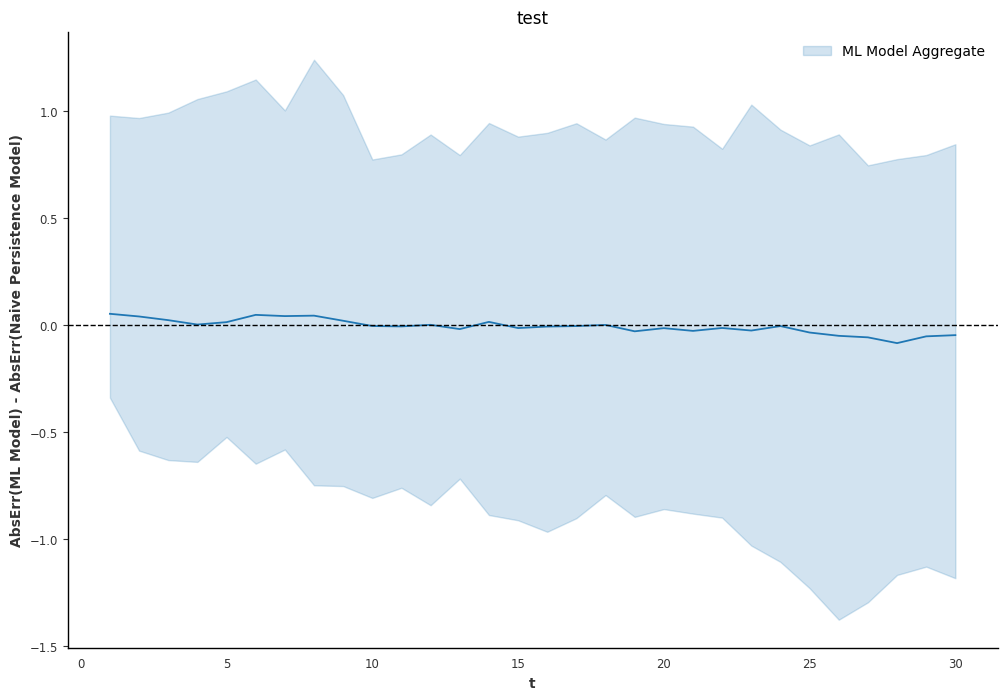

In [109]:
plot_crps_over_time_agg(intra_merged, 'test', 'ae')